# Chicken Weights by Feed Type

## Description

An experiment was conducted to measure and compare the effectiveness of various feed supplements on the growth rate of chickens.

## Format

A data frame with 71 observations on the following 2 variables.

- weight: a numeric variable giving the chick weight.

- feed: a factor giving the feed type.

## Details

Newly hatched chicks were randomly allocated into six groups, and each group was given a different feed supplement. Their weights in grams after six weeks are given along with feed types.

This dataset is built-in. You can load it with the command 

`data(chickwts)`


In [2]:
library(dplyr)
library(R2jags)

data(chickwts)

Source: local data frame [2 x 3]

       feed   mean       sd
1 horsebean 160.20 38.62584
2   linseed 218.75 52.23570

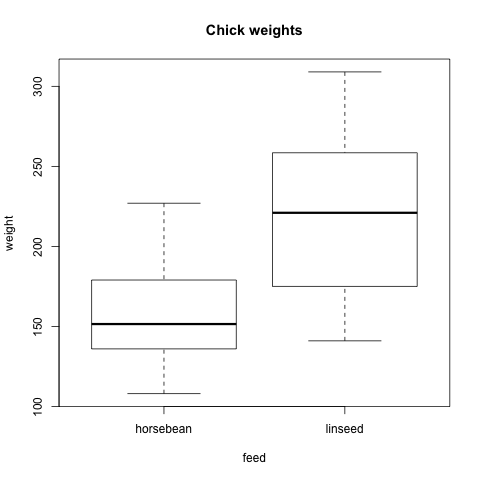

In [2]:
## Restrict to two groups
chickwts <- chickwts %>% filter(feed %in% c("horsebean", "linseed"))

## Drop unused factor levels
chickwts$feed = factor(chickwts$feed)


chickwts %>% group_by(feed) %>%
    summarise(mean = mean(weight),
              sd = sd(weight))

## Plot data
plot(weight ~ feed, data = chickwts, main = "Chick weights")

In [30]:
## traditional t test
t.test(weight ~ feed, data = chickwts, var.eq=TRUE)


	Two Sample t-test

data:  weight by feed
t = -2.934, df = 20, p-value = 0.008205
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -100.17618  -16.92382
sample estimates:
mean in group horsebean   mean in group linseed 
                 160.20                  218.75 


In [4]:
## create index variable for Jags
chickwts$feed_ix <- match(chickwts$feed, unique(chickwts$feed))
head(chickwts)
tail(chickwts)

  weight      feed feed_ix
1    179 horsebean       1
2    160 horsebean       1
3    136 horsebean       1
4    227 horsebean       1
5    217 horsebean       1
6    168 horsebean       1

   weight    feed feed_ix
17    148 linseed       2
18    169 linseed       2
19    213 linseed       2
20    257 linseed       2
21    244 linseed       2
22    271 linseed       2

In [7]:
modelstr <- "
model {
 for (i in 1:n_obs) {
    y[i] ~ dnorm(mu[i], tau)

    mu[i] <- beta[feed[i]]
  }
  for (j in 1:2) {
  beta[j] ~ dnorm(0, 1e-03)
  }

  tau <- pow(sigma, -2)
  sigma ~ dunif(0, 60)

  # contrast
  difference <- beta[1] - beta[2]
}"

In [8]:
jagsdata <- list(y = chickwts$weight,
                 feed = chickwts$feed_ix,
                 n_obs = length(chickwts$weight))

inits <- function() {
    list(beta = rnorm(2, 0, 100))
}

parameters = c("beta", "difference", "sigma")

In [10]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr),
            inits = inits, n.chains = 2,
            n.iter = 2000, n.thin = 2,n.burnin = 100,
            parameters.to.save = parameters)
print(fit)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 55

Initializing model

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
           mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
beta[1]    124.127  15.597  91.489 114.207 124.780 134.542 154.330 1.002   830
beta[2]    175.658  15.183 146.264 165.559 175.794 186.212 205.022 1.001  1900
difference -51.531  20.463 -92.302 -65.110 -52.209 -37.917  -9.808 1.001  1700
sigma       54.072   4.636  43.152  51.352  55.085  57.882  59.774 1.002  1600
deviance   244.605   6.734 233.933 239.838 243.673 248.690 259.736 1.002  1300

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 22.7 and DIC = 267.3
DIC is an estimate of expected predic